
## Predicting In-Hospital Mortality in ICU Patients
This notebook outlines the process of predicting in-hospital mortality risk for patients in an Intensive Care Unit (ICU) using data from the PhysioNet Challenge. The focus is on Event 2, which involves estimating the probability of in-hospital death.

### Approach
We will employ a machine learning pipeline to handle data preprocessing, model training, and evaluation. The pipeline integrates steps for handling missing values, scaling features, and applying a Random Forest classifier to predict the probability of in-hospital death.

### Steps
1. **Model Selection**: Starting with a Random Forest classifier to establish a baseline model
2. **Random Forest characteristics**: OOB, Tree Visualization and Bias-Variance tradeoffs
3. **Model Evaluation**: Utilizing metrics like AUC-ROC and calibration plots to assess performance (Hosmer-Lemeshow goodness of fit test)
4. **Model Calibration & cross validation**: Adjusting model probabilities to accurately represent true risk levels


#### This approach aims to not only predict mortality risk accurately but also ensure that the model's probabilistic outputs are well-calibrated and interpretable, which is crucial in a healthcare setting.


## 0. Data Ingestion
Below is a function to ingest individual patient files. Each file contains time-series data for a single patient, and the filename corresponds to the patient's RecordID

In [38]:
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import chi2


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import plot_tree




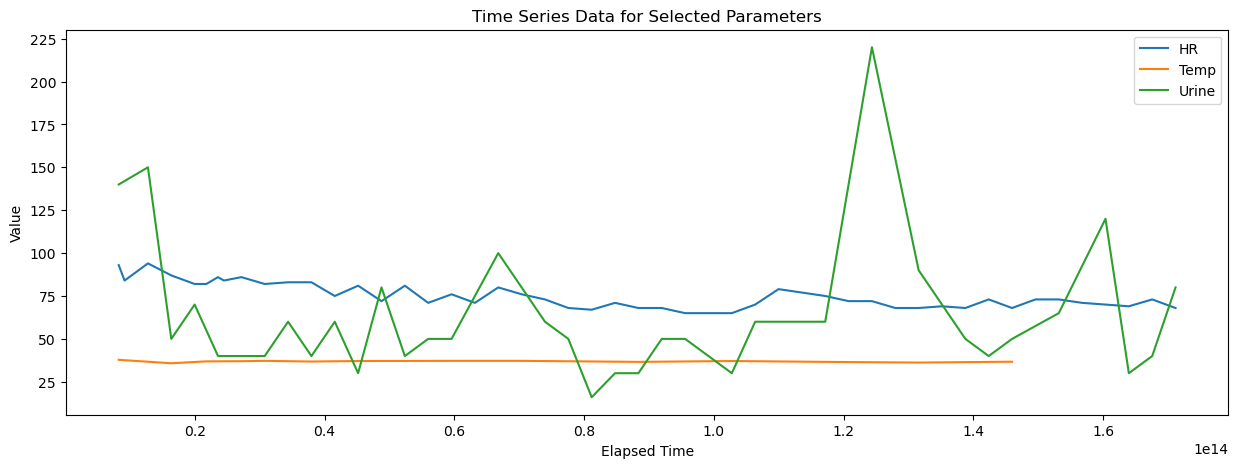

In [3]:
# Visualize the data

# Function to convert time string to timedelta
def time_to_timedelta(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return pd.Timedelta(hours=hours, minutes=minutes)

# Load the data
sample_data_path = 'sample/132545.txt'
sample_df = pd.read_csv(sample_data_path)

# Convert 'Time' to timedelta
sample_df['Time'] = sample_df['Time'].apply(time_to_timedelta)

# Choose parameters to plot
parameters_to_plot = ['HR', 'Temp', 'Urine']  # Add or remove parameters as needed

# Plotting
plt.figure(figsize=(15, 5))
for parameter in parameters_to_plot:
    param_df = sample_df[sample_df['Parameter'] == parameter]
    plt.plot(param_df['Time'], param_df['Value'], label=parameter)

plt.xlabel('Elapsed Time')
plt.ylabel('Value')
plt.title('Time Series Data for Selected Parameters')
plt.legend()
plt.show()


## 0.1. Data Preprocessing
The data is pivoted and aggregated to create a wide-format dataset where each row represents a single patient's summary statistics over the first 48 hours of their ICU stay.

@article{silva2012predicting,
  title={Predicting in-hospital mortality of icu patients: The physionet/computing in cardiology challenge 2012},
  author={Silva, Ikaro and Moody, George and Scott, Daniel J and Celi, Leo A and Mark, Roger G},
  journal={Computing in cardiology},
  volume={39},
  pages={245},
  year={2012},
  publisher={NIH Public Access}
}

In [39]:
data = pd.read_csv('PhysionetChallenge2012-set-a.csv.gz', compression='gzip')

In [6]:
data.shape

(4000, 120)

In [89]:
data.describe()

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,3997.000000,2106.000000,3669.000000,...,2780.000000,205.000000,863.000000,3908.000000,2718.000000,3038.000000,2529.000000,2529.000000,2529.000000,2529.000000
mean,137605.122000,14.203500,6.402500,13.441750,128.735500,0.138500,64.247500,0.561921,171.985856,81.474832,...,122.461871,6.466341,1.002283,12.303224,85.037344,7.398693,285.176750,1912.005140,0.620799,12.314749
std,2923.608886,6.088584,4.201298,12.246371,363.714273,0.345467,17.560946,0.496213,83.781865,23.305130,...,23.676777,9.594861,2.395043,6.591505,24.090094,0.061213,484.275957,872.032383,0.485284,5.896841
min,132539.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,15.000000,0.000000,121.900000,35.000000,...,7.000000,0.300000,0.010000,1.000000,35.000000,7.030000,0.000000,0.000000,0.000000,1.000000
25%,135075.750000,11.000000,3.000000,6.000000,-1.000000,0.000000,52.750000,0.000000,162.600000,66.000000,...,106.000000,0.700000,0.040000,8.500000,68.500000,7.370000,53.000000,1170.000000,0.000000,8.000000
50%,137592.500000,15.000000,6.000000,10.000000,-1.000000,0.000000,67.000000,1.000000,170.200000,78.700000,...,121.000000,2.000000,0.130000,11.200000,82.200000,7.400000,122.000000,2320.000000,1.000000,13.000000
75%,140100.250000,18.000000,9.000000,17.000000,16.000000,0.000000,78.000000,1.000000,177.800000,92.000000,...,138.000000,7.900000,0.760000,14.800000,97.600000,7.440000,242.000000,2670.000000,1.000000,16.000000
max,142673.000000,34.000000,22.000000,154.000000,2600.000000,1.000000,90.000000,1.000000,3960.000000,280.000000,...,260.000000,49.200000,24.040000,162.000000,280.000000,7.660000,2859.000000,2870.000000,1.000000,44.000000


## 1. Model Selection: Starting with a Random Forest classifier to establish a baseline model

We're loading the dataset, separating features (X) from target variable (y), and splitting the data into training and testing sets. We're also setting up a pipeline that includes steps for imputation (to handle missing data), scaling (to standardize the features), and the classifier itself.

In [40]:

# Load the dataset
physionet_data = data.copy()

# Drop the "Survival" column from the dataset
physionet_data = physionet_data.drop(columns=['Survival'])

# Splitting the dataset into features and target variable
X = physionet_data.drop(columns=['In-hospital_death'])
y = physionet_data['In-hospital_death']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up a simple Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    random_state=42)

# Creating a pipeline with imputation and scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])


### 1.1  Train the Random Forest Model

In [41]:
# Train the pipeline (includes imputation, scaling, and random forest classifier)
pipeline.fit(X_train, y_train)

# Predicting probabilities on the training set
y_test_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [42]:
rf_classifier = pipeline.named_steps['classifier']

display(Markdown(f"Number of trees: {len(rf_classifier.estimators_)}"))
display(Markdown(f"Maximum depth of trees: {rf_classifier.max_depth}"))
display(Markdown(f"Random Forest hyperparameters: {rf_classifier.get_params()}"))


Number of trees: 50

Maximum depth of trees: 10

Random Forest hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

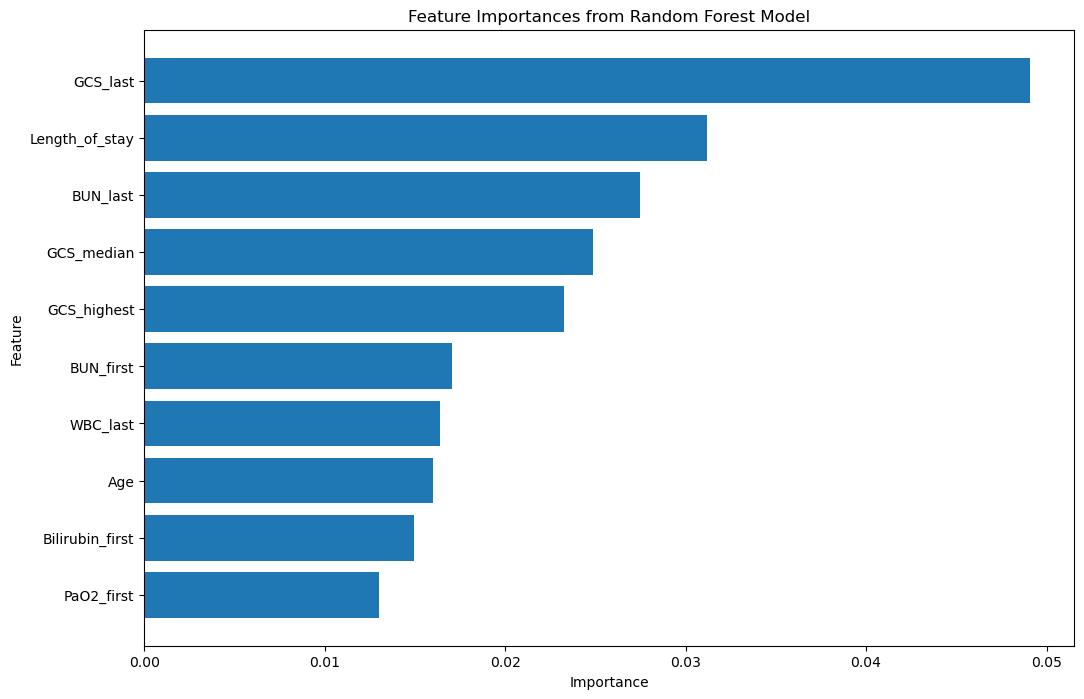

In [43]:
# Access the random forest model from the pipeline
rf_model = pipeline.named_steps['classifier']

# Extract feature importances
importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance for better visualization
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [48]:
# extract a list of the feature names from importances_df
feature_names = importances_df['Feature'].values
feature_names

array(['GCS_last', 'Length_of_stay', 'BUN_last', 'GCS_median',
       'GCS_highest', 'BUN_first', 'WBC_last', 'Age', 'Bilirubin_first',
       'PaO2_first'], dtype=object)

# 2. Random Forest characteristics: OOB, Tree Visualization and Bias-Variance tradeoffs

### 2.1. Out-of-Bag (OOB) Error
Random Forest can be configured to provide an OOB error estimate, which is a way of measuring prediction error on the training set by only using the trees that did not see a particular data point during training

In [14]:
# Setting up a simple Random Forest classifier
rf_oob = RandomForestClassifier(
    n_estimators=50,
    oob_score=True, 
    max_depth=10, 
    random_state=42)

# Creating a pipeline with imputation and scaling
pipeline_oob = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', rf_oob)
])

pipeline_oob.fit(X_train, y_train)

# Extract the OOB error rate
oob_error = 1 - rf_oob.oob_score_
display(Markdown(f"OOB Error Rate: {oob_error:.4f}"))


OOB Error Rate: 0.1238

### 2.2. Tree Visualization
Visualizing a single decision tree from the Random Forest ensemble can provide insights into the decision-making process of the model

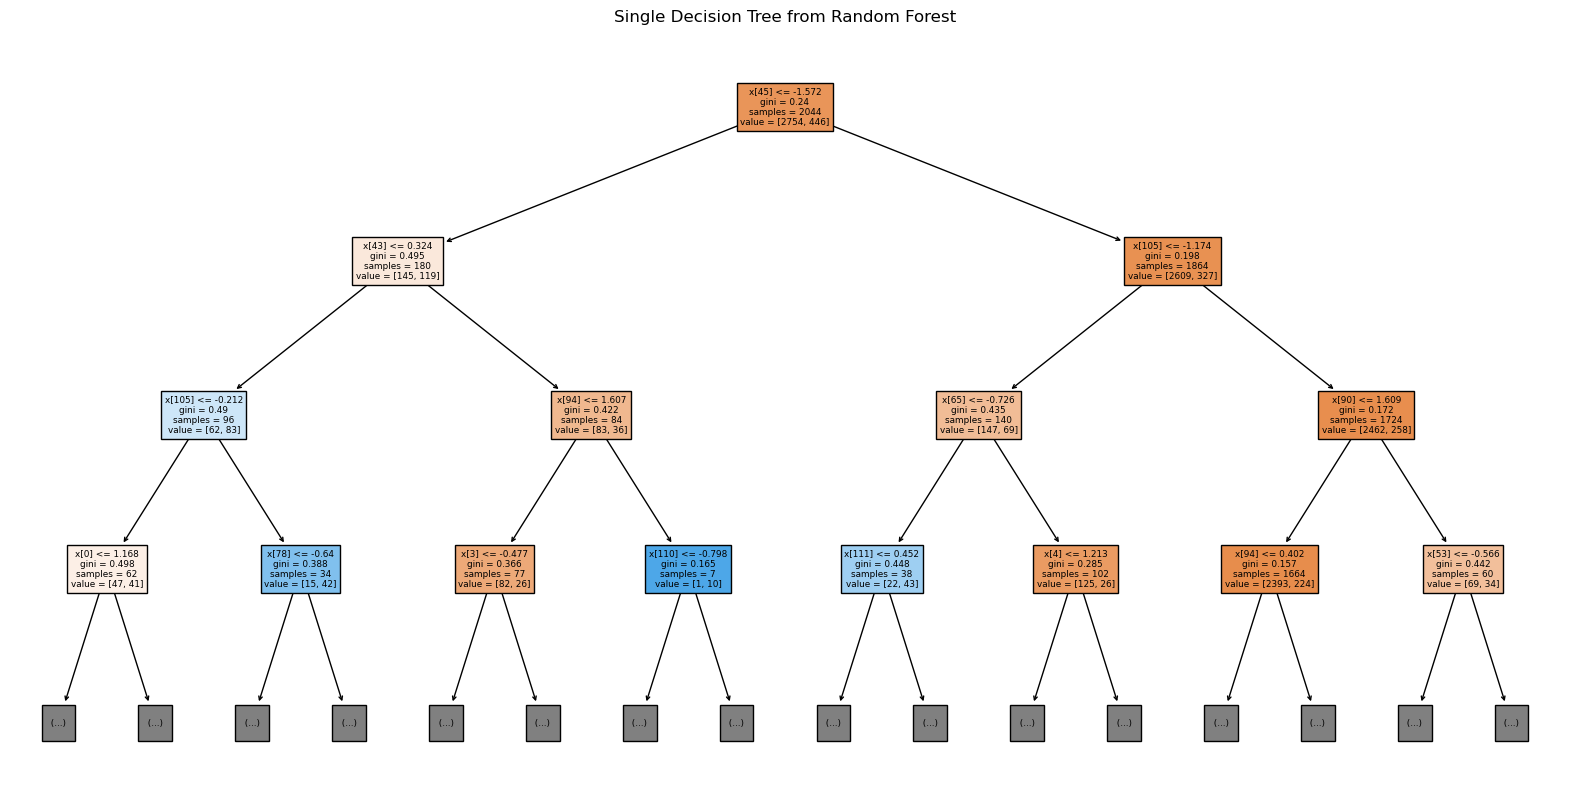

In [15]:
# Extract a single tree from the Random Forest within the pipeline
single_tree = pipeline_oob.named_steps['classifier'].estimators_[0]

# Plot the single tree without specifying feature names
plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, max_depth=3)
plt.title("Single Decision Tree from Random Forest")
plt.show()

### 2.3. Bias-Variance Tradeoff Analysis
This analysis involves plotting the model's performance against varying model complexity (like the number of trees).

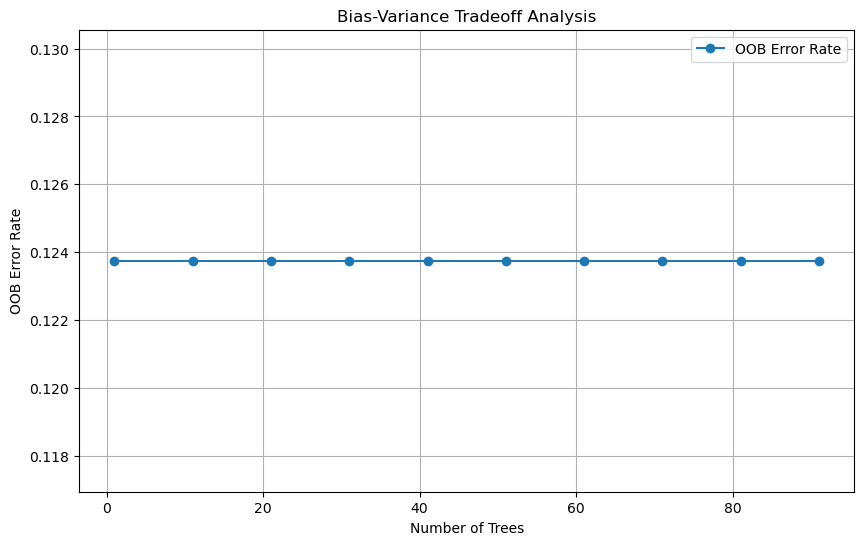

In [16]:
# Varying the number of trees and recording the OOB error
tree_range = range(1, 101, 10)
oob_errors = []

for n_trees in tree_range:
    oob_error = 1 - pipeline_oob.named_steps['classifier'].oob_score_
    oob_errors.append(oob_error)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(tree_range, oob_errors, label='OOB Error Rate', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('Bias-Variance Tradeoff Analysis')
plt.legend()
plt.grid(True)
plt.show()


## 3. Model Evaluation: Utilizing metrics like AUC-ROC and calibration plots to assess performance

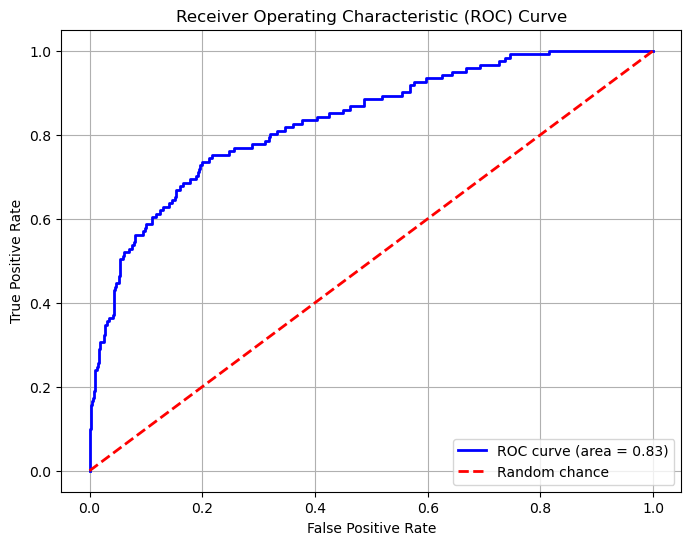

In [17]:
# Evaluate performance
# Plot ROC Curve

# Calculate AUC-ROC
test_auc_roc = roc_auc_score(y_test, y_test_proba)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### 3.1 Hosmer-Lemeshow goodness of fit test

The AUC-ROC Looks impressive, but let's look deeper nto the model's performance. We'll use the Hosmer-Lemeshow goodness of fit test to assess the model's calibration, e.g. we'll test how well a model predicts outcomes in real life. This test divides patients into groups based on their predicted chances of passIn-Hosital-death and then comparing these with how many actually passed

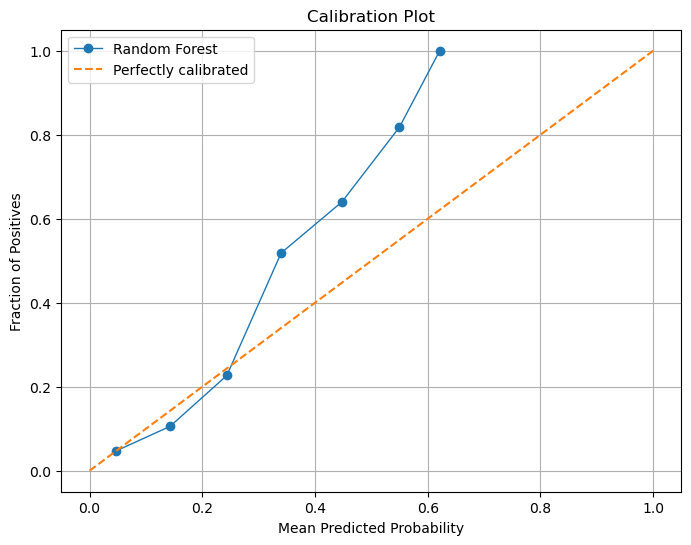

In [18]:
# Generating the calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Updated function to calculate the Hosmer-Lemeshow goodness of fit test
def calculate_h_and_d(y_true, y_proba, num_groups=10):
    # Ensure that probabilities are within the range [0.01, 0.99]
    y_proba = np.clip(y_proba, 0.01, 0.99)

    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    # Sort the predicted probabilities and corresponding true labels
    sorted_indices = np.argsort(y_proba)
    y_true_sorted = y_true[sorted_indices]
    y_proba_sorted = y_proba[sorted_indices]

    # Split the data into equal-sized groups
    groups = np.array_split(range(len(y_true)), num_groups)

    # Calculate the observed and expected frequencies for each group
    observed_freq = np.zeros(num_groups)
    expected_freq = np.zeros(num_groups)
    mean_risk = np.zeros(num_groups)

    for i, group in enumerate(groups):
        observed_freq[i] = np.sum(y_true_sorted[group])
        expected_freq[i] = np.sum(y_proba_sorted[group])
        mean_risk[i] = np.mean(y_proba_sorted[group])

    # Calculate the H statistic
    h_statistic = np.sum((observed_freq - expected_freq) ** 2 / (expected_freq * (1 - mean_risk) + 0.001))

    # Calculate D value
    d_value = mean_risk[-1] - mean_risk[0]

    return h_statistic, d_value


In [20]:
h_statistic, d_value = calculate_h_and_d(y_test, y_test_proba)

prob_true, prob_pred

# Calculate the degrees of freedom
num_groups = 10
df = num_groups - 2
# Calculate the p-value
p_value = 1 - chi2.cdf(h_statistic, df)

# Calculate the Event 2 score
event_2_score = h_statistic / d_value

In [21]:
# Display the results with text
display(Markdown(f"**P-value:** {p_value}"))
display(Markdown(f"**H statistic:** {h_statistic}"))
display(Markdown(f"**D value:** {d_value}"))
display(Markdown(f"**Event 2 value:** {event_2_score}"))

**P-value:** 0.005042217311025388

**H statistic:** 21.932626502235834

**D value:** 0.41290993920843383

**Event 2 value:** 53.11721617619965

1. **P value (0.005)**: the p-value is quite low. This is the probability of obtaining the observed data (or data more extreme) if the model fits the data well. This leads to the conclusion that the model does not fit the data well, according to the Hosmer-Lemeshow test

2. **H statistic (21.9)**: This is the Hosmer-Lemeshow H statistic, and measures the goodness of fit of the RF model. A smaller H statistic indicates a better fit of the model. In this case, the H statistic is relatively high, suggesting that the model may not fit the data well

3. **D value (0.41)**: This is the difference between the mean predicted probabilities in the top and bottom deciles. This value indicates the spread or range of the predicted probabilities. A large D value means that the model is able to distinguish between low-risk and high-risk individuals more effectively. 0.6015, is condiered as a moderate level of discrimination

4. **Event 2 value (53)**: This is the Event 2 score, defined as H/D. This score is a range-normalized measure of the goodness of fit. A smaller Event 2 score indicates a better fit of the model, taking into account both the calibration (H statistic) and the discrimination (D value) of the model. YThe relative high Event 2 value, suggests that the model may not fit the data well when considering both calibration and discrimination

# 4. Model calibration

Let's now calibrate our Random Forest model using isotonic regression (a non-parametric technique that refines predicted probabilities to align closely with observed frequencies). 

This process is essential in clinical settings to ensure that the model's risk estimates are trustworthy and actionable. 

Properly calibrated probabilities are critical for clinicians making life-or-death decisions based on the model's output, ensuring that the predicted risk levels reflect true likelihoods of patient outcomes.

In [35]:
# Calibrate the model on the validation data using isotonic regression
calibrated_clf = CalibratedClassifierCV(estimator=pipeline, method='isotonic', cv=20)
calibrated_clf.fit(X_test, y_test)

# Predict probabilities on the validation set after calibration
y_test_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC for the calibrated model
test_auc_roc_calibrated = roc_auc_score(y_test, y_test_proba_calibrated)
display(Markdown(f'Validation AUC-ROC (Calibrated): {test_auc_roc_calibrated:.2f}'))



Validation AUC-ROC (Calibrated): 1.00

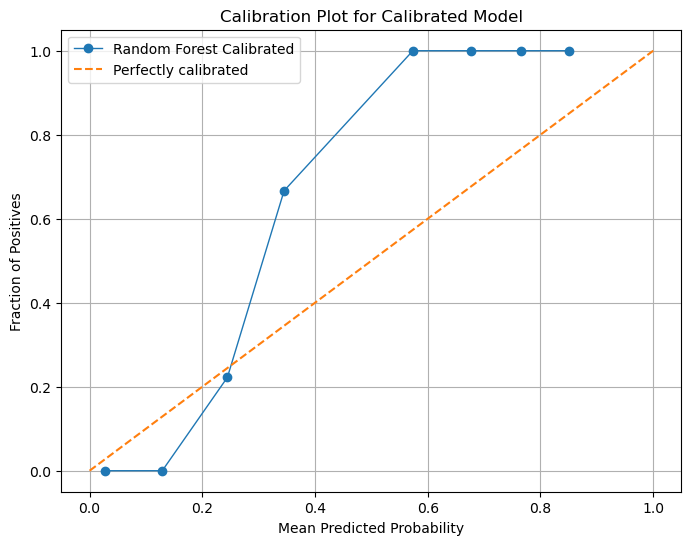

In [36]:
# Generate and plot the calibration curve for the calibrated model
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_test_proba_calibrated, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Random Forest Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot for Calibrated Model')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
h_statistic_calib, d_value_calib = calculate_h_and_d(y_test, y_test_proba_calibrated)

# Calculate the degrees of freedom
num_groups = 10
df = num_groups - 2
# Calculate the p-value
p_value_calib = 1 - chi2.cdf(h_statistic_calib, df)

# Calculate the Event 2 score
event_2_score_calib = h_statistic_calib / d_value_calib

# Comparisson
calibrated_vs_non = pd.DataFrame({
    'Metric': ['P-value', 'H statistic', 'D value', 'Event 2 score'],
    'Calibrated': [p_value_calib, h_statistic_calib, d_value_calib, event_2_score_calib],
    'Original': [p_value, h_statistic, d_value, event_2_score]  
})

calibrated_vs_non['Original'] = calibrated_vs_non['Original'].round(2)
calibrated_vs_non

,Metric,Calibrated,Original
0,P-value,0.000018,0.01
1,H statistic,35.961370,21.93
2,D value,0.840928,0.41
3,Event 2 score,42.763905,53.12
